In [1]:
from numba import jit

In [2]:
# simple class to take care of statistically determined quantities
class Cumulants:
    def __init__(self):
        self.sum=0.0    # f_0 + f_1 +.... + f_N
        self.sqsum=0.0  # f_0^2 + f_1^2 +....+ f_N^2
        self.avg = 0.0  # I_best when many iterations, otherwise <f> = 1/N\sum_i f_i
        self.err = 0.0  # sigma of I_best when many iterations, otherwise sqrt( <f^2>-<f>^2 )/sqrt(N)
        self.chisq = 0.0
        self.weightsum=0.0 # \sum_i 1/sigma_i^2
        self.avgsum=0.0    # \sum_i <f>_i/sigma_i^2
        self.avg2sum=0.0   # \sum_i <f>_i^2/sigma_i^2

Numba is hard to use on the class. We will define a simple function `RefineGrid__` (not class member), which contains the part of the code that takes most time, and the class will call the external function `RefineGrid__`

In [3]:
@jit(nopython=True)
def RefineGrid__(imp, self_g):
    (ndim,nbins) = shape(imp)
    gnew = zeros((ndim,nbins+1))
    for idim in range(ndim):
        avgperbin = sum(imp[idim,:])/nbins
        #**** redefine the size of each bin  ****
        newgrid = zeros(nbins)
        cur=0.0
        newcur=0.0
        thisbin = 0.0
        ibin = -1
        # we are trying to determine
        #   Int[ f(g) dg, {g, g_{i-1},g_i}] == I/N_g
        #   where I == avgperbin
        for newbin in range(nbins-1):  # all but the last bin, which is 1.0
            while (thisbin < avgperbin) :
                ibin+=1
                thisbin += imp[idim,ibin]
                prev = cur
                cur = self_g[idim,ibin]
            # Explanation is in order : 
            #   prev    -- g^{old}_{l-1}
            #   cur     -- g^{old}_l
            #   thisbin -- Sm = f_{l-k}+.... +f_{l-2}+f_{l-1}+f_l
            #   we know that  Sm is just a bit more than we need, i.e., I/N_g, hence we need to compute how much more
            #   using linear interpolation :
            #   g^{new} = g_l - (g_l-g_{l-1}) * (f_{l-k}+....+f_{l-2}+f_{l-1}+f_l - I/N_g)/f_l
            #    clearly
            #         if I/N_g == f_{l-k}+....+f_{l-2}+f_{l-1}+f_l
            #            we will get g^{new} = g_l
            #     and if I/N_g == f_{l-k}+....+f_{l-2}+f_{l-1}
            #            we will get g^{new} = g_{l-1}
            #     and if I/N_g  is between the two possibilities, we will get linear interpolation between
            #     g_{l-1} and g_l
            #     
            thisbin -= avgperbin   # thisbin <- (f_{l-k}+....+f_{l-2}+f_{l-1}+f_l - I/N_g)
            delta = (cur - prev)*thisbin # delta <-  (g_l-g_{l-1})*(f_{l-k}+....+f_{l-2}+f_{l-1}+f_l - I/N_g)
            # cur is the closest point from the old mesh, while delta/imp is the correction using linear interpolation.
            newgrid[newbin] = cur - delta/imp[idim,ibin]  

        newgrid[nbins-1]=1.0
        gnew[idim,:nbins]= newgrid
    return gnew

class Grid:
    """Contains the grid points g_n(x) with x=[0...1], and g=[0...1]
       for Vegas integration. There are n-dim g_n functions.
       Constraints : g(0)=0 and g(1)=1.
    """
    def __init__(self, ndim, nbins):
        self.g = zeros((ndim,nbins+1))  
        # a bit dirty trick: We will later use also g[-1] in interpolation, which should be set to zero, hence
        # we allocate dimension nbins+1, rather than nbinx
        self.ndim=ndim
        self.nbins=nbins
        # At the beginning we set g(x)=x
        # The grid-points are x_0 = 1/N, x_1 = 2/N, ... x_{N-1}=1.0. 
        # Note that g(0)=0, and we skip this point on the mesh.
        for idim in range(ndim):
            self.g[idim,:nbins] = arange(1,nbins+1)/float(nbins)
       
    def RefineGrid(self, imp): # Now just a call to external function, which handless class mmber self.g
        self.g = RefineGrid__(imp, self.g)

In [4]:
from numpy import *

def smfun(x):
    if (x>0):
        return ((x-1.)/log(x))**(1.5)
    else:
        return 0.
vsmfun = vectorize(smfun)

def Smoothen(fxbin):
    (ndim,nbins) = shape(fxbin)
    final = zeros(shape(fxbin))
    for idim in range(ndim):
        fxb = copy(fxbin[idim,:])
        #**** smooth the f^2 value stored for each bin ****
        # f[i] <- (f[i+1]+f[i]+f[i-1])/3.
        fxb[:nbins-1] += fxbin[idim,1:nbins]
        fxb[1:nbins]  += fxbin[idim,:nbins-1]
        fxb[1:nbins-1] *= 1/3.
        fxb[0] *= 1/2.
        fxb[nbins-1] *= 1/2.
        norm = sum(fxb)
        if( norm == 0 ):
            print ('ERROR can not refine the grid with zero grid function')
            return # can not refine the grid if the function is zero.
        fxb *= 1.0/norm         # we normalize the function.
        # Note that normalization is such that the sum is 1.
        final[idim,:] = vsmfun(fxb)
    return final

To speed up the code, we will define external function `SetFxbin`, which iterates over large loop n=1000, and sets the projections of the function. This external function can be speed up by `numba`.

In addition, we will generalize the code for complex functions, and generalized interval $[a,b]$.

In [5]:
@jit(nopython=True)
def SetFxbin(fxbin,bins,wfun):
    (n,ndim) = bins.shape
    for dim in range(ndim):
        # Here we make a better approximation for the function, which we are integrating.
        for i in range(n):
            fxbin[dim, bins[i,dim] ] += abs(wfun[i]) # just bin the function f. We saved the bin position before.                


def Vegas_step4(integrant, ab, maxeval, nstart, nincrease, grid, cum):
    ndim, nbins = grid.ndim,grid.nbins  # dimension of the integral, size of the grid for binning in each direction
    unit_dim = (ab[1]-ab[0])**ndim   # CHANGED: converts from unit cube integration to generalized cube with unit length
    nbatch=1000             # function will be evaluated in bacthes of 1000 evaluations at one time (for efficiency and storage issues)
    neval=0
    print ("""Vegas parameters:
       ndim = """+str(ndim)+"""
       limits = """+str(ab)+"""
       maxeval = """+str(maxeval)+"""
       nstart = """+str(nstart)+"""
       nincrease = """+str(nincrease)+"""
       nbins = """+str(nbins)+"""
       nbaths = """+str(nbatch)+"\n")

    bins = zeros((nbatch,ndim),dtype=int) # in which sampled bin does this point fall?
    
    all_nsamples = nstart
    for iter in range(1000):
        wgh = zeros(nbatch)            # weights for each random point in the batch
        fxbin = zeros((ndim,nbins))    # after each iteration we reset the average function being binned
        for nsamples in range(all_nsamples,0,-nbatch):  # loop over all_nsample evaluations in batches of nbatch
            n = min(nbatch,nsamples)  # How many evaluations in this pass?
            # We are integrating f(g_1(x),g_2(y),g_3(z))*dg_1/dx*dg_2/dy*dg_3/dz dx*dy*dz
            # This is represented as  1/all_nsamples \sum_{x_i,y_i,z_i} f(g_1(x_i),g_2(y_i),g_3(z_i))*dg_1/dx*dg_2/dy*dg_3/dz
            #  where dg_1/dx = diff*NBINS
            xr = random.random((n,ndim)) # generates 2-d array of random numbers in the interval [0,1)
            pos = xr*nbins                   # (x*N)
            bins = array(pos,dtype=int)      # which grid would it fit ? (x*N)
            wgh = ones(nbatch)/all_nsamples
            for dim in range(ndim):   
                # We want to evaluate the function f at point g(x), i.e, f(g_1(x),g_2(y),...)
                # Here we transform the points x,y,z -> g_1(x), g_2(y), g_3(z)
                # We hence want to evaluate g(x) ~ g(x[i]), where x is the random number and g is the grid function
                # The discretized g(t) is defined on the grid :
                #       t[-1]=0, t[0]=1/N, t[1]=2/N, t[2]=3/N ... t[N-1]=1.
                # We know that g(0)=0 and g(1)=1, so that g[-1]=0.0 and g[N-1]=1.0
                # To interpolate g at x, we first compute  i=int(x*N) and then we use linear interpolation
                # g(x) = g[i-1] + (g[i]-g[i-1])*(x*N-int(x*N))
                gi = grid.g[dim,bins[:,dim]]            # g[i]
                gm = grid.g[dim,bins[:,dim]-1]          # g[i-1]
                diff = gi - gm                          # g[i]-g[i-1]
                gx = gm + (pos[:,dim]-bins[:,dim])*diff # linear interpolation g(x)
                xr[:,dim] = gx*(ab[1]-ab[0])+ab[0]      # xr [a,b] <- g(xr)\in [0,1]
                wgh *= diff*nbins                       # wgh = prod_{dim} dg/dx
            
            # Here we evaluate function f on all randomly generated x points above
            fx = integrant(xr)  # n function evaluations required in single call
            neval += n  # We just added so many fuction evaluations
            
            # Now we compute the integral as weighted average, namely, f(g(x))*dg/dx
            wfun = wgh * fx             # weight * function ~ f_i*w_i            
            cum.sum += sum(wfun)        # sum_i f_i*w_i = <fw>
            wfun *= conj(wfun)          # CHANGED FOR COMPLEX carefull : this is like  (f_i * w_i/N)^2 hence  1/N (1/N (f_i*w_i)^2)
            cum.sqsum += sum(wfun).real # sum_i (f_i*w_i)^2 = <fw^2>/all_nsamples
            # 
            SetFxbin(fxbin,bins,wfun)
                
        w1 = cum.sqsum*all_nsamples-abs(cum.sum)**2   # w1 = <fw^2>-<fw>^2
        w = (all_nsamples-1)/w1            # w ~ 1/sigma_i^2 = (N-1)/(<fw^2>-<fw>^2)
        # Note that variance of the MC sampling is Var(monte-f) = (<f^2>-<f>^2)/N == 1/sigma_i^2
        cum.weightsum += w          # weightsum ~ \sum_i 1/sigma_i^2
        cum.avgsum += w*cum.sum     # avgsum    ~ \sum_i <fw>_i / sigma_i^2
        #cum.avg2sum += w*abs(cum.sum)**2  # avg2cum   ~ \sum_i <fw>_i^2/sigma_i^2
        
        cum.avg = cum.avgsum/cum.weightsum     # I_best = (\sum_i <fw>_i/sigma_i^2 )/(\sum_i 1/sigma_i^2)
        cum.err = sqrt(1/cum.weightsum)        # err ~ sqrt(best sigma^2) = sqrt(1/(\sum_i 1/sigma_i^2))
        
        chisq=0
        if iter>0:
            cum.chisq += abs(cum.sum - cum.avg)**2*w
            chisq = cum.chisq/iter
            #print('<f>/sigma^2',cum.avgsum, '1/sigma^2', cum.weightsum)
            #print('<f^2>=', cum.sqsum*all_nsamples, '<f>^2=', abs(cum.sum)**2, '<f^2>-<f>^2=', cum.sqsum*all_nsamples-abs(cum.sum)**2)
        print ("Iteration {:3d}: I= {:10.8f} +- {:10.8f}  chisq= {:10.8f} number of evaluations = {:7d} ".format(iter+1, cum.avg*unit_dim, cum.err*unit_dim, chisq, neval))
        imp = Smoothen(fxbin)
        grid.RefineGrid(imp)
        
        cum.sum=0                    # clear the partial sum for the next step
        cum.sqsum=0
        all_nsamples += nincrease    # for the next time, increase the number of steps a bit
        if (neval>=maxeval): break
            
    cum.chisq *= 1./(iter)
    cum.avg *= (ab[1]-ab[0])**ndim
    cum.err *= (ab[1]-ab[0])**ndim

In [6]:
def my_integrant2(x):
    """ For testing, we are integration the function
       1/(1-cos(x)*cos(y)*cos(z))/pi^3
       in the interval [0,pi]**3
    """
    return 1.0/(1.0-cos(x[:,0])*cos(x[:,1])*cos(x[:,2]))/pi**3

In [13]:
from scipy import *
from numpy import *

ndim=3
maxeval=2000000
exact = 1.3932*(2**3)  # exact value of the integral
    
cum = Cumulants()
    
nbins=128
nstart =100000
nincrease=5000

grids = Grid(ndim,nbins)

Vegas_step4(my_integrant2, [-pi,pi], maxeval, nstart, nincrease, grids, cum)

print (cum.avg, '+-', cum.err, 'exact=', exact, 'real error=', abs(cum.avg-exact)/exact)

Vegas parameters:
       ndim = 3
       limits = [-3.141592653589793, 3.141592653589793]
       maxeval = 2000000
       nstart = 100000
       nincrease = 5000
       nbins = 128
       nbaths = 1000

Iteration   1: I= 11.08948981 +- 0.10589730  chisq= 0.00000000 number of evaluations =  100000 
Iteration   2: I= 11.10184093 +- 0.04102108  chisq= 0.00240157 number of evaluations =  205000 
Iteration   3: I= 11.11313548 +- 0.02881990  chisq= 0.03814671 number of evaluations =  315000 
Iteration   4: I= 11.13454692 +- 0.02373830  chisq= 0.41362074 number of evaluations =  430000 
Iteration   5: I= 11.13385261 +- 0.01985602  chisq= 0.31071376 number of evaluations =  550000 
Iteration   6: I= 11.13725477 +- 0.01707352  chisq= 0.26522780 number of evaluations =  675000 
Iteration   7: I= 11.14409943 +- 0.01547126  chisq= 0.34397730 number of evaluations =  805000 
Iteration   8: I= 11.15196353 +- 0.01406965  chisq= 0.47130356 number of evaluations =  940000 
Iteration   9: I= 11.14481266

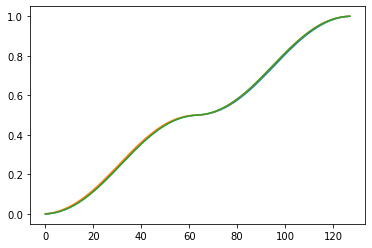

In [14]:
from pylab import *
%matplotlib inline

plot(grids.g[0,:nbins])
plot(grids.g[1,:nbins])
plot(grids.g[2,:nbins])

In [15]:
@jit(nopython=True)
def ferm(x):
    if x>700:
        return 0.
    else: 
        return 1./(exp(x)+1.)
    

@jit(nopython=True)
def Linhard_inside(x, Omega, q, res, kF, T, broad, nrm):
    # k[n,ndim]
    for i in range(x.shape[0]):
        k = x[i,0:3]
        e_k_q = linalg.norm(k-q)**2 - kF*kF
        e_k = linalg.norm(k)**2 - kF*kF
        dfermi = (ferm(e_k_q/T)-ferm(e_k/T))
        #print('e(k)=', e_k, 'e(k-q)=',e_k_q), 'dfermi=', dfermi
        res[i] = -2*nrm*dfermi/(Omega-e_k_q+e_k+broad*1j)
    return res

class Linhard:
    def __init__(self, Omega, q, kF, T, broad):
        self.Omega = Omega
        self.q = array([0,0,q])
        self.kF = kF
        self.T = T
        self.broad = broad
        self.nrm = 1/(2*pi)**3
    def __call__(self, k):
        res = zeros(k.shape[0], dtype=complex)
        return Linhard_inside(k, self.Omega, self.q, res, self.kF, self.T, self.broad, self.nrm)

In [24]:
from numpy import random

kF=0.1
lh = Linhard(0.0, 0.1*kF,kF,0.02*kF,0.002*kF)
x = random.random((4,3))
lh(x)

array([-6.58584663e-149+1.17808667e-150j,
       -2.18840891e-265+2.29625438e-267j,
       -1.32196372e-263+2.34180620e-265j,
       -4.53747045e-135+9.72676825e-137j])

In [28]:
from numpy import *

# As required by the homework
rs = 2.
kF = pow( 9*pi/4., 1./3.) / rs
nF = kF/(2*pi*pi)
T = 0.02*kF**2
broad = 0.002*kF**2
cutoff = 3*kF
Omega=0.0*kF**2
q = 0.1*kF


ndim=3
FCT=1
maxeval=int(10000000/FCT)
nbins=128
nstart =int(200000/FCT)
nincrease=int(100000/FCT)

cum = Cumulants()
grids = Grid(ndim,nbins)
lh = Linhard(Omega, q, kF, T, broad)
Vegas_step4(lh, [-cutoff,cutoff], maxeval, nstart, nincrease, grids, cum)

Vegas parameters:
       ndim = 3
       limits = [-2.878737439016269, 2.878737439016269]
       maxeval = 10000000
       nstart = 200000
       nincrease = 100000
       nbins = 128
       nbaths = 1000

Iteration   1: I= -0.04817395-0.00002083j +- 0.00157088  chisq= 0.00000000 number of evaluations =  200000 
Iteration   2: I= -0.04800597-0.00002454j +- 0.00025669  chisq= 0.00031381 number of evaluations =  500000 
Iteration   3: I= -0.04773526-0.00000932j +- 0.00016542  chisq= 0.39644113 number of evaluations =  900000 
Iteration   4: I= -0.04777332+0.00000121j +- 0.00012622  chisq= 0.29077575 number of evaluations = 1400000 
Iteration   5: I= -0.04779456+0.00001192j +- 0.00010513  chisq= 0.23818712 number of evaluations = 2000000 
Iteration   6: I= -0.04773979+0.00000361j +- 0.00009050  chisq= 0.34939421 number of evaluations = 2700000 
Iteration   7: I= -0.04774531+0.00000176j +- 0.00007896  chisq= 0.29336772 number of evaluations = 3500000 
Iteration   8: I= -0.04776300-0.000008

(-0.9832961281977085-0.00018469022414319743j) +- 0.0009070416397151927


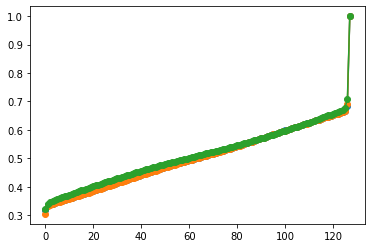

In [29]:
print (cum.avg/nF, '+-', cum.err/nF)

plot(grids.g[0,:nbins],'o-')
plot(grids.g[1,:nbins],'o-')
plot(grids.g[2,:nbins],'o-')

Defining Linhardt susceptibility, which evaluates polarization for the entire array of frequencies $\Omega$.

In [37]:
@jit(nopython=True)
def Linhard2_inside(x, Omega, q, res, kF, T, broad, nrm):
    for i in range(x.shape[0]):
        k = x[i,0:3]
        e_k_q = linalg.norm(k-q)**2 - kF*kF
        e_k = linalg.norm(k)**2 - kF*kF
        dfermi = (ferm(e_k_q/T)-ferm(e_k/T))
        #print('e(k)=', e_k, 'e(k-q)=',e_k_q), 'dfermi=', dfermi
        res[:,i] = -2*nrm*dfermi/(Omega-e_k_q+e_k+broad*1j)
    return res

class Linhard2:
    def __init__(self, Omega, q, kF, T, broad):
        self.Omega = Omega
        self.q = array([0,0,q])
        self.kF = kF
        self.T = T
        self.broad = broad
        self.nrm = 1/(2*pi)**3
    def __call__(self, x):
        #print(x)
        res = zeros((len(self.Omega),x.shape[0]), dtype=complex)
        #print('shape(res)=', shape(res))
        return Linhard2_inside(x, self.Omega, self.q, res, self.kF, self.T, self.broad, self.nrm)

In [38]:
from numpy import random
Omega = linspace(0,kF**2,10)
lh2 = Linhard2(Omega, q, kF, T, broad)
x = random.random((4,3))
y=lh2(x)
print(y.shape)
y

(10, 4)


array([[-1.33459558e-09+2.02275051e-10j, -1.11785302e-10+1.94131689e-12j,
        -5.04589003e-20+5.61316075e-22j, -5.85411613e-04+1.15789909e-05j],
       [-1.44891406e-10+2.33118733e-12j, -5.69065741e-11+5.02984814e-13j,
        -3.11881164e-20+2.14425779e-22j, -2.79005034e-04+2.62930413e-06j],
       [-7.65207716e-11+6.50084091e-13j, -3.81672445e-11+2.26252266e-13j,
        -2.25685758e-20+1.12278663e-22j, -1.83137773e-04+1.13279324e-06j],
       [-5.19871730e-11+3.00044992e-13j, -2.87121054e-11+1.28036790e-13j,
        -1.76817518e-20+6.89184271e-23j, -1.36302339e-04+6.27471492e-07j],
       [-3.93656958e-11+1.72037717e-13j, -2.30114408e-11+8.22411613e-14j,
        -1.45345349e-20+4.65677135e-23j, -1.08543288e-04+3.97914676e-07j],
       [-3.16754380e-11+1.11385881e-13j, -1.91994523e-11+5.72502786e-14j,
        -1.23383877e-20+3.35581660e-23j, -9.01777662e-05+2.74650979e-07j],
       [-2.64987646e-11+7.79533036e-14j, -1.64709316e-11+4.21342467e-14j,
        -1.07187903e-20+2.532632

Class for Cumulants has to be upgraded, so that allows arrays in frequency (for all values of $\Omega$).
Note that some quantities need to be complex arrays, and some real arrays.

In [32]:
class CumulantsW:
    def __init__(self, Om):
        nOm = len(Om)
        self.sum=zeros(nOm, dtype=complex)    # f_0 + f_1 +.... + f_N
        self.sqsum=zeros(nOm)                 # |f_0|^2 + |f_1|^2 +....+ |f_N|^2
        self.avg = zeros(nOm, dtype=complex)  # I_best when many iterations, otherwise <f> = 1/N\sum_i f_i
        self.err = zeros(nOm)                 # sigma of I_best when many iterations, otherwise sqrt( <f^2>-<f>^2 )/sqrt(N)
        self.chisq = zeros(nOm)
        self.weightsum=zeros(nOm)             # \sum_i 1/sigma_i^2
        self.avgsum=zeros(nOm, dtype=complex) # \sum_i <f>_i/sigma_i^2
        self.avg2sum=zeros(nOm)               # \sum_i <f>_i^2/sigma_i^2
        

Finally, Vegas is changed so that functions $f$ returns 2D-array $(\Omega,n)$. All quantities in cumulants are now arrays in frequency.

In [39]:
def Vegas_step5(integrant, ab, maxeval, nstart, nincrease, grid, cum):
    ndim, nbins = grid.ndim,grid.nbins  # dimension of the integral, size of the grid for binning in each direction
    unit_dim = (ab[1]-ab[0])**ndim   # converts from unit cube integration to generalized cube with unit length
    nbatch=1000             # function will be evaluated in bacthes of 1000 evaluations at one time (for efficiency and storage issues)
    neval=0
    print ("""Vegas parameters:
       ndim = """+str(ndim)+"""
       limits = """+str(ab)+"""
       maxeval = """+str(maxeval)+"""
       nstart = """+str(nstart)+"""
       nincrease = """+str(nincrease)+"""
       nbins = """+str(nbins)+"""
       nbaths = """+str(nbatch)+"\n")

    bins = zeros((nbatch,ndim),dtype=int) # in which sampled bin does this point fall?
    
    
    all_nsamples = nstart
    for iter in range(1000):
        wgh = zeros(nbatch)            # weights for each random point in the batch
        fxbin = zeros((ndim,nbins))    # after each iteration we reset the average function being binned
        for nsamples in range(all_nsamples,0,-nbatch):  # loop over all_nsample evaluations in batches of nbatch
            n = min(nbatch,nsamples)  # How many evaluations in this pass?
            # We are integrating f(g_1(x),g_2(y),g_3(z))*dg_1/dx*dg_2/dy*dg_3/dz dx*dy*dz
            # This is represented as  1/all_nsamples \sum_{x_i,y_i,z_i} f(g_1(x_i),g_2(y_i),g_3(z_i))*dg_1/dx*dg_2/dy*dg_3/dz
            #  where dg_1/dx = diff*NBINS
            xr = random.random((n,ndim)) # generates 2-d array of random numbers in the interval [0,1)
            pos = xr*nbins                   # (x*N)
            bins = array(pos,dtype=int)      # which grid would it fit ? (x*N)
            wgh = ones(nbatch)/all_nsamples
            for dim in range(ndim):   
                # We want to evaluate the function f at point g(x), i.e, f(g_1(x),g_2(y),...)
                # Here we transform the points x,y,z -> g_1(x), g_2(y), g_3(z)
                # We hence want to evaluate g(x) ~ g(x[i]), where x is the random number and g is the grid function
                # The discretized g(t) is defined on the grid :
                #       t[-1]=0, t[0]=1/N, t[1]=2/N, t[2]=3/N ... t[N-1]=1.
                # We know that g(0)=0 and g(1)=1, so that g[-1]=0.0 and g[N-1]=1.0
                # To interpolate g at x, we first compute  i=int(x*N) and then we use linear interpolation
                # g(x) = g[i-1] + (g[i]-g[i-1])*(x*N-int(x*N))
                gi = grid.g[dim,bins[:,dim]]            # g[i]
                gm = grid.g[dim,bins[:,dim]-1]          # g[i-1]
                diff = gi - gm                          # g[i]-g[i-1]
                gx = gm + (pos[:,dim]-bins[:,dim])*diff # linear interpolation
                xr[:,dim] = gx*(ab[1]-ab[0])+ab[0]      # xr <- g(xr)
                wgh *= diff*nbins                       # wgh = prod_{dim} dg/dx
            
            # Here we evaluate function f on all randomly generated x points above
            fx = integrant(xr)  # n function evaluations required in single call fx[Om,i]
            neval += n  # We just added so many fuction evaluations
            
            # Now we compute the integral as weighted average, namely, f(g(x))*dg/dx
            wfun = fx * wgh             # weight * function ~ wfun[om,i] = f[om,i]*w[i]            
            cum.sum += sum(wfun,axis=1) # <fw>[om] = sum_i f[om,i]*w[i]
            wfun2 = abs(wfun*conj(wfun))*all_nsamples # <fw^2>[om,i] = (|f[om,i]|^2*w[i]^2*N)
            cum.sqsum += sum(wfun2, axis=1).real # <fw^2>[om] = sum_i <fw^2>[om,i]   
            #
            SetFxbin(fxbin,bins,wfun2[0,:])

        w1 = cum.sqsum-abs(cum.sum)**2   # w1 = <fw^2>[om]-<fw>[om]^2
        w = (all_nsamples-1)/w1            # w ~ 1/sigma_i^2 = (N-1)/(<fw^2>-<fw>^2)
        # Note that variance of the MC sampling is Var(monte-f) = (<f^2>-<f>^2)/N == 1/sigma_i^2
        cum.weightsum += w          # weightsum[om] ~ \sum_i 1/sigma_i^2
        cum.avgsum += w*cum.sum     # avgsum[om]    ~ \sum_i <fw>_i / sigma_i^2
        cum.avg2sum += w*abs(cum.sum)**2  # avg2cum[om]   ~ \sum_i <fw>_i^2/sigma_i^2
        
        cum.avg = cum.avgsum/cum.weightsum     # I_best[om] = (\sum_i <fw>_i/sigma_i^2 )/(\sum_i 1/sigma_i^2)
        cum.err = sqrt(1/cum.weightsum)        # err[om] ~ sqrt(best sigma^2) = sqrt(1/(\sum_i 1/sigma_i^2))
        
        chisq=0
        if iter>0:
            cum.chisq += abs(cum.sum - cum.avg)**2*w
            chisq = cum.chisq[0]/iter
        print ("Iteration {:3d}: I= {:10.8f} +- {:10.8f}  chisq= {:10.8f} number of evaluations = {:7d} ".format(iter+1, cum.avg[0]*unit_dim, cum.err[0]*unit_dim, chisq, neval))
        imp = Smoothen(fxbin)
        grid.RefineGrid(imp)
        
        cum.sum[:]=0                    # clear the partial sum for the next step
        cum.sqsum[:]=0
        all_nsamples += nincrease    # for the next time, increase the number of steps a bit
        if (neval>=maxeval): break
            
    cum.chisq *= 1./(iter)
    cum.avg *= unit_dim
    cum.err *= unit_dim

In [40]:
from numpy import *

Omega = linspace(0,0.5*kF**2,100)
lh2 = Linhard2(Omega, q, kF, T, broad)
cum = CumulantsW(Omega)
ndim=3
grids = Grid(ndim,nbins)

Vegas_step5(lh2, [-cutoff,cutoff], maxeval, nstart, nincrease, grids, cum)

Vegas parameters:
       ndim = 3
       limits = [-2.878737439016269, 2.878737439016269]
       maxeval = 10000000
       nstart = 200000
       nincrease = 100000
       nbins = 128
       nbaths = 1000

Iteration   1: I= -0.04772948-0.00008652j +- 0.00157365  chisq= 0.00000000 number of evaluations =  200000 
Iteration   2: I= -0.04809082+0.00000631j +- 0.00025791  chisq= 0.00155136 number of evaluations =  500000 
Iteration   3: I= -0.04798252+0.00000708j +- 0.00016431  chisq= 0.06101368 number of evaluations =  900000 
Iteration   4: I= -0.04784380+0.00000038j +- 0.00012617  chisq= 0.38293118 number of evaluations = 1400000 
Iteration   5: I= -0.04779470+0.00000648j +- 0.00010462  chisq= 0.37174841 number of evaluations = 2000000 
Iteration   6: I= -0.04786105+0.00001268j +- 0.00009039  chisq= 0.53631704 number of evaluations = 2700000 
Iteration   7: I= -0.04780991+0.00001434j +- 0.00007898  chisq= 0.61942510 number of evaluations = 3500000 
Iteration   8: I= -0.04784314+0.000014

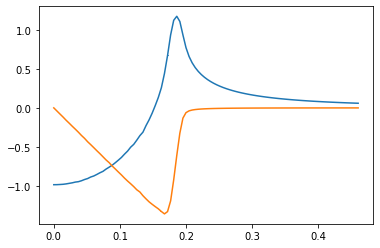

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
errorbar(Omega,cum.avg.real/nF, yerr=cum.err)
errorbar(Omega,cum.avg.imag/nF, yerr=cum.err);

(-0.9835836744083016-5.9723154387385916e-05j) +- 0.0009153277374235508


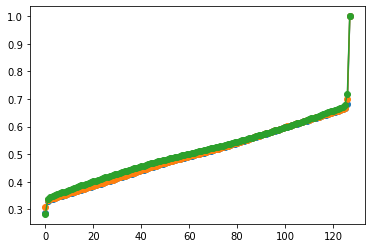

In [36]:
print (cum.avg[0]/nF, '+-', cum.err[0]/nF)

plot(grids.g[0,:nbins],'o-')
plot(grids.g[1,:nbins],'o-')
plot(grids.g[2,:nbins],'o-')